In [46]:
# Import all modules for exploratory data analysis

# Extract and save data from database
import db_utils as dbu
# Change datatype of columns to the appripriate ones
import pre_processing as prep
# Get descritve informarion from the dataframe
import extract_info as extract 

In [37]:
# Extract cloud database credentials from yaml file
db_credentials = dbu.read_credentials("/Users/ChAre/OneDrive/Desktop/aicore/EDA_finance/credentials.yaml")

# Extracting the data from Amazon RDS

In [38]:
# Initialise RDSDatabaseConnector class
db_connector = dbu.RDSDatabaseConnector(db_credentials)

In [ ]:
# Connect to database and extract desire database in the cloud
# RDSDatabaseConnector.save_data() call upon: extract_data, 
db_connector.save_data()

In [39]:
# Load data into pyhton
df_unclean = db_connector.load_data("./loan_payments")

# Data preprocessing

In [40]:
# Inspect the columns data types
df_unclean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           54231 non-null  int64  
 1   member_id                    54231 non-null  int64  
 2   loan_amount                  54231 non-null  int64  
 3   funded_amount                51224 non-null  float64
 4   funded_amount_inv            54231 non-null  float64
 5   term                         49459 non-null  object 
 6   int_rate                     49062 non-null  float64
 7   instalment                   54231 non-null  float64
 8   grade                        54231 non-null  object 
 9   sub_grade                    54231 non-null  object 
 10  employment_length            52113 non-null  object 
 11  home_ownership               54231 non-null  object 
 12  annual_inc                   54231 non-null  float64
 13  verification_sta

In [41]:
# Create instance of preprocessing of DataTransform class for preprocessing.
df_prep = prep.DataTransform(df_unclean)

In [ ]:
# Transform columns into the categorical data type
df_prep.category_transform(["grade", "sub_grade", "home_ownership", "verification_status", "loan_status", "payment_plan", "purpose", "application_type", "employment_length", "policy_code"])

In [ ]:
# Convert columns to date type data
df_prep.date_transform(["issue_date", "earliest_credit_line", "last_payment_date", "next_payment_date", "last_credit_pull_date"])

In [42]:
# Preporcess term column

# Convert column values into strings
df_prep.string_transform(["term"])

# Remove unwanted characters from the column values
df_prep.remove_characters("term", ["months"])

# Transform column values to numeric
df_prep.numeric_transform(["term"])

#Rename column to reflect the unit for the values
df_prep.rename_column("term", "term_in_months")

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_in_months,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.00,0.00,Jan-2022,248.82,Feb-2022,Jan-2022,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.00,0.00,Jan-2022,407.52,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.00,0.00,Oct-2021,12850.16,NaN,Oct-2021,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.00,0.00,Jun-2021,13899.67,NaN,Jun-2021,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.00,0.00,Jan-2022,456.54,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.00,0.00,Jul-2016,160.61,NaN,Jul-2016,NaN,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,0.00,0.00,Oct-2016,490.01,NaN,Sep-2016,0.0,NaN,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.00,0.00,Sep-2016,110.58,Sep-2016,May-2013,NaN,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.00,0.00,Mar-2014,0.00,NaN,May-2013,NaN,NaN,1,INDIVIDUAL


In [43]:
# Create DataFrameInfo instance to extract useful information from the dataframe.
df_inf = extract.DataFrameInfo(df_prep.dataframe)

In [ ]:
# Check the data types of the columns after the transformations.
df_inf.check_columns_type()

In [ ]:
# Extract statistical values: median, standard deviation and mean from the columns
# Omitted the id and member_id columns because they are used just for identifying individuals
df_inf.descriptive_stats( ["id", "member_id"]) 

In [ ]:
# Count distinct values in categorical columns
df_inf.unique_valus_count()

In [ ]:
# Print out the shape of the DataFrame
df_inf.data_shape()

In [ ]:
# Generate a count/percentage count of NULL values in each column
df_inf.count_null(percentage=True)

Base on the percentage of missing data I decided to:
drop:
 - mths_since_last_delinq:        57.2% missing values.
 - mths_since_last_record:        88.6% missing values.

Impute:
- funded_amount                   5.5% missing values
- term_in_months                  8.8% missing values
- int_rate                        9.5% missing values
- employment_length               3.9% missing values
- last_payment_date               0.1% missing values
- last_credit_pull_date           0.013% missing values
- collections_12_mths_ex_med      0.094% missing values
- mths_since_last_major_derog     86.2% missing values

Although the next_payment_date column has 86.2% of missing values, it can be useful to project profit in the following months. Therefore I chose to impute it. I also prioritise imputing values rather than droppoing rows since it will will reduce the data in other column makeing it less reliable to impute values.

In [ ]:
# Dropping columns
df_prep.remove_columns(["mths_since_last_delinq", "mths_since_last_record"])

Since most of the columns to impute have a low percentage of missing data I decide to use the mean or the median. To decide which of the two method I should use for each column I will carry a normality test for each column.

In [19]:
from scipy.stats import normaltest
def norm_test(dataframe, column):
    data = dataframe[column]
    stat, p = normaltest(data, nan_policy='omit')
    print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=4491.436, p=0.000


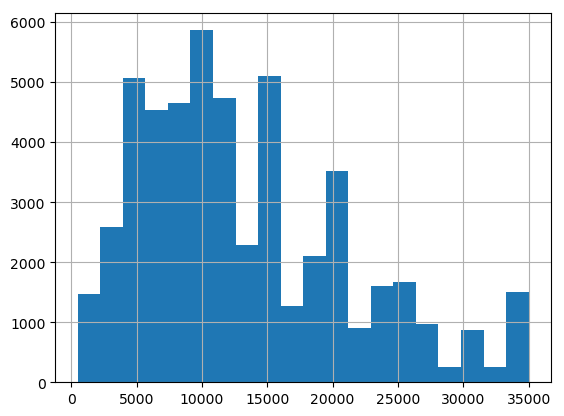

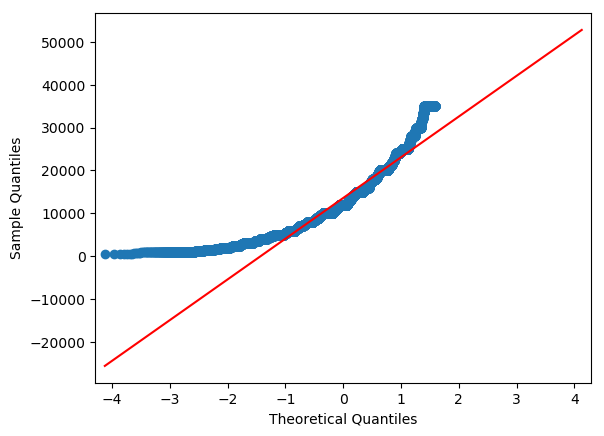

In [20]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
# Normality test
norm_test(df_prep.dataframe, "funded_amount")
# Historgram
df_prep.dataframe["funded_amount"].hist(bins=20)
# QQplot
qq_plot = qqplot(df_prep.dataframe["funded_amount"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is skewed and therefore i will use the median.


In [ ]:
# Imputing "funded_amount" using the median

# Get the mendian
df_inf.descriptive_stats("funded_amount")
# replace null values
df_prep.replace_null("funded_amount", 12000.0)


Statistics=16516.551, p=0.000


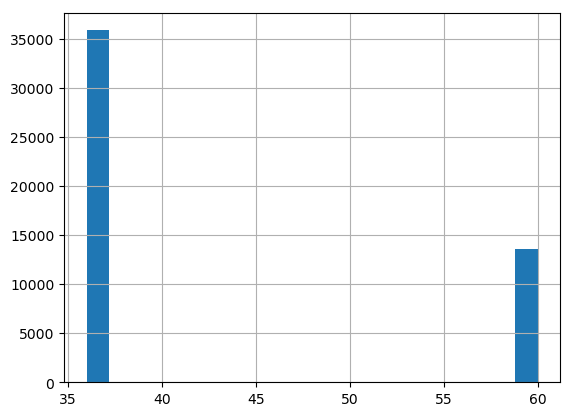

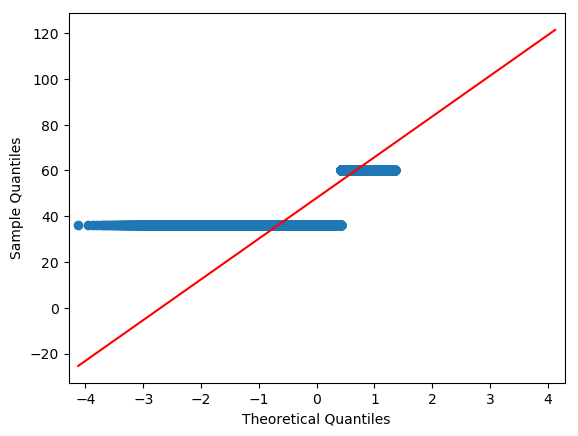

In [49]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
# Normality test
norm_test(df_prep.dataframe, "term_in_months")
# Historgram
df_prep.dataframe["term_in_months"].hist(bins=20)
# QQplot
qq_plot = qqplot(df_prep.dataframe["term_in_months"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is only two values and since is categorical we impute the null values using the median. 

In [57]:
# Impute values of the "term_in_months" column

# Get the mendian
df_inf.descriptive_stats("term_in_months")
# replace null values
df_prep.replace_null("term_in_months", 36.0)


 
loan_amount: 
 mean:13333.08  
 median:12000.0 
 standard_deviation:8082.2

 
funded_amount: 
 mean:13161.34  
 median:12000.0 
 standard_deviation:7798.6

 
funded_amount_inv: 
 mean:12952.62  
 median:11300.0 
 standard_deviation:8099.47

 
term_in_months: 
 mean:42.61  
 median:36.0 
 standard_deviation:10.72

 
int_rate: 
 mean:13.51  
 median:13.16 
 standard_deviation:4.39

 
instalment: 
 mean:400.01  
 median:347.15 
 standard_deviation:238.92

 
annual_inc: 
 mean:72220.85  
 median:61000.0 
 standard_deviation:51589.34

 
dti: 
 mean:15.87  
 median:15.6 
 standard_deviation:7.62

 
delinq_2yrs: 
 mean:0.24  
 median:0.0 
 standard_deviation:0.71

 
inq_last_6mths: 
 mean:0.89  
 median:1.0 
 standard_deviation:1.26

 
mths_since_last_delinq: 
 mean:34.02  
 median:31.0 
 standard_deviation:21.92

 
mths_since_last_record: 
 mean:74.83  
 median:87.0 
 standard_deviation:36.14

 
open_accounts: 
 mean:10.56  
 median:10.0 
 standard_deviation:4.8

 
total_accounts: 
 mean:

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_in_months,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.00,0.00,Jan-2022,248.82,Feb-2022,Jan-2022,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.00,0.00,Jan-2022,407.52,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.00,0.00,Oct-2021,12850.16,NaN,Oct-2021,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.00,0.00,Jun-2021,13899.67,NaN,Jun-2021,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.00,0.00,Jan-2022,456.54,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.00,0.00,Jul-2016,160.61,NaN,Jul-2016,NaN,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,0.00,0.00,Oct-2016,490.01,NaN,Sep-2016,0.0,NaN,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.00,0.00,Sep-2016,110.58,Sep-2016,May-2013,NaN,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.00,0.00,Mar-2014,0.00,NaN,May-2013,NaN,NaN,1,INDIVIDUAL


Statistics=1421.934, p=0.000


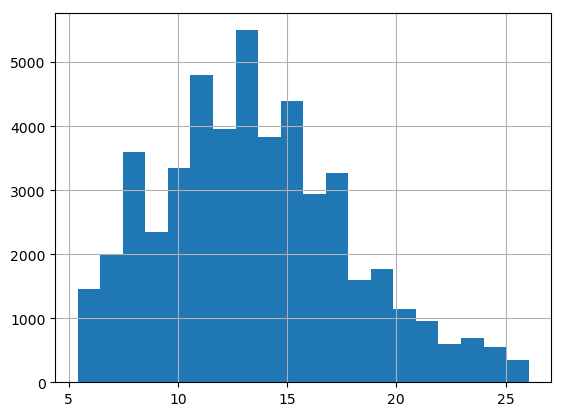

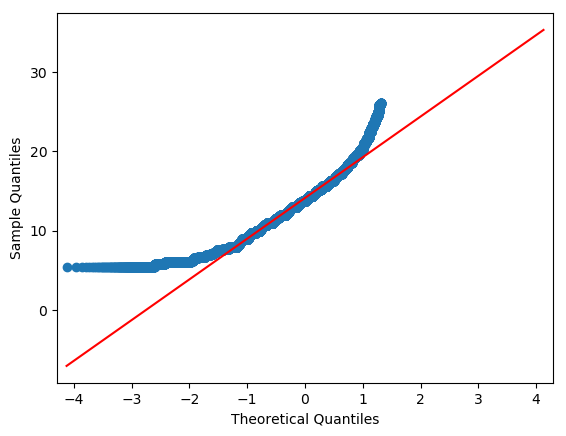

In [59]:
# Normality test
norm_test(df_prep.dataframe, "int_rate")
# Historgram
df_prep.dataframe["int_rate"].hist(bins=20)
# QQplot
qq_plot = qqplot(df_prep.dataframe["int_rate"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is skewed and therefore i will use the median.

In [65]:
# Impute values of the "term_in_months" column

# Get the mendian
df_inf.descriptive_stats("int_rate")
# replace null values
df_prep.replace_null("int_rate", 13.16)


 
loan_amount: 
 mean:13333.08  
 median:12000.0 
 standard_deviation:8082.2

 
funded_amount: 
 mean:13161.34  
 median:12000.0 
 standard_deviation:7798.6

 
funded_amount_inv: 
 mean:12952.62  
 median:11300.0 
 standard_deviation:8099.47

 
term_in_months: 
 mean:42.02  
 median:36.0 
 standard_deviation:10.41

 
int_rate: 
 mean:13.51  
 median:13.16 
 standard_deviation:4.39

 
instalment: 
 mean:400.01  
 median:347.15 
 standard_deviation:238.92

 
annual_inc: 
 mean:72220.85  
 median:61000.0 
 standard_deviation:51589.34

 
dti: 
 mean:15.87  
 median:15.6 
 standard_deviation:7.62

 
delinq_2yrs: 
 mean:0.24  
 median:0.0 
 standard_deviation:0.71

 
inq_last_6mths: 
 mean:0.89  
 median:1.0 
 standard_deviation:1.26

 
mths_since_last_delinq: 
 mean:34.02  
 median:31.0 
 standard_deviation:21.92

 
mths_since_last_record: 
 mean:74.83  
 median:87.0 
 standard_deviation:36.14

 
open_accounts: 
 mean:10.56  
 median:10.0 
 standard_deviation:4.8

 
total_accounts: 
 mean:

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_in_months,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.00,0.00,Jan-2022,248.82,Feb-2022,Jan-2022,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.00,0.00,Jan-2022,407.52,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.00,0.00,Oct-2021,12850.16,NaN,Oct-2021,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.00,0.00,Jun-2021,13899.67,NaN,Jun-2021,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.00,0.00,Jan-2022,456.54,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.00,0.00,Jul-2016,160.61,NaN,Jul-2016,NaN,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,0.00,0.00,Oct-2016,490.01,NaN,Sep-2016,0.0,NaN,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.00,0.00,Sep-2016,110.58,Sep-2016,May-2013,NaN,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.00,0.00,Mar-2014,0.00,NaN,May-2013,NaN,NaN,1,INDIVIDUAL


In [66]:
df_prep.dataframe["int_rate"].isnull().sum()
#df_prep.dataframe["term_in_months"].value_counts()
#df_prep.dataframe["int_rate"].skew()
#df_prep.dataframe["int_rate"]


0

In [ ]:
import seaborn as sns
sns.histplot(data = df_prep.dataframe["funded_amount"], x= "funded_amount")
sns.despine()